In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import yfinance as yf

In [3]:
import datetime

In [4]:
spy = yf.download('^NSEI', start='2007-09-17', end='2024-05-23')


[*********************100%%**********************]  1 of 1 completed


In [5]:
df2 = spy['Adj Close']

In [6]:
scaler=MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(4086, 1)

In [7]:
x= int(0.8*len(df2))
training_data=df2[0:x,:]
testing_data = df2[x:,:]

In [8]:
testing_data.shape

(818, 1)

In [9]:
def create_data(data, seq_len):
    X,Y= [],[]
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [10]:
seq_len=45
X_train,Y_train =  create_data(training_data,seq_len)
X_test,Y_test =  create_data(testing_data,seq_len)

In [11]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(3223, 45)
[[0.09740429 0.09995255 0.10915441 ... 0.1672129  0.16725243 0.16098686]
 [0.09995255 0.10915441 0.10990577 ... 0.16725243 0.16098686 0.15011912]
 [0.10915441 0.10990577 0.1143547  ... 0.16098686 0.15011912 0.1480578 ]
 ...
 [0.51162652 0.51479266 0.50655969 ... 0.58118299 0.5930394  0.59914678]
 [0.51479266 0.50655969 0.5108776  ... 0.5930394  0.59914678 0.5964601 ]
 [0.50655969 0.5108776  0.51420937 ... 0.59914678 0.5964601  0.5856616 ]]
(773, 45)
(773,)


In [12]:
# inputs=tf.keras.layers.Input(shape=(X_train.shape[1],1))
# model=LSTM(50,return_sequences=True,activation="tanh")(inputs)
# model=LSTM(50,return_sequences = True,activation="tanh")(model)
# model=Dropout(0.2)(model)
# model=LSTM(50,activation="tanh")(model)
# model=Dropout(0.2)(model)
# model=Dense(25)(model)
# model=Dense(1)(model)
# model=Model(inputs, model)
# model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics=['mae'])
# too many layers causing overfiiting

In [13]:
inputs=tf.keras.layers.Input(shape=(X_train.shape[1],1))
model1=LSTM(50,return_sequences=True)(inputs)
model1=LSTM(50, return_sequences=True)(model1)
model1=LSTM(50)(model1)
model1=Dense(1)(model1)
model1=Model(inputs, model1)

2024-05-25 03:04:58.773175: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-25 03:04:58.773201: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-25 03:04:58.773213: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-25 03:04:58.773253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 03:04:58.773271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 45, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 45, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_mean_absolute_error', threshold=0.0060):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if current < self.threshold:
                print(f"\nEpoch {epoch + 1}: Early stopping threshold reached. Validation MAE: {current}")
                self.model.stop_training = True
early_stopping = CustomEarlyStopping(monitor='val_mae', threshold=0.0060)

In [16]:
with tf.device("/gpu:0"):  # Assuming your GPU is at index 0
  model1.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
  model1.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 150,batch_size = 64,callbacks=[early_stopping])

Epoch 1/150


2024-05-25 03:05:01.234677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 6s 58ms/step - loss: 0.0060 - mae: 0.0472 - val_loss: 0.0014 - val_mae: 0.0307
Epoch 2/150
51/51 [==============================] - 1s 27ms/step - loss: 2.6333e-04 - mae: 0.0113 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 3/150
51/51 [==============================] - 1s 27ms/step - loss: 2.3756e-04 - mae: 0.0107 - val_loss: 8.7167e-04 - val_mae: 0.0239
Epoch 4/150
51/51 [==============================] - 1s 27ms/step - loss: 2.2254e-04 - mae: 0.0103 - val_loss: 6.7395e-04 - val_mae: 0.0210
Epoch 5/150
51/51 [==============================] - 1s 26ms/step - loss: 2.2726e-04 - mae: 0.0106 - val_loss: 0.0011 - val_mae: 0.0277
Epoch 6/150
51/51 [==============================] - 1s 27ms/step - loss: 2.1183e-04 - mae: 0.0101 - val_loss: 9.3849e-04 - val_mae: 0.0252
Epoch 7/150
51/51 [==============================] - 1s 27ms/step - loss: 1.9514e-04 - mae: 0.0097 - val_loss: 0.0013 - val_mae: 0.0307
Epoch 8/150
51/51 [==============================] -

In [17]:
train_predict = model1.predict(X_train)
test_predict = model1. predict(X_test)

25/25 [==============================] - 0s 9ms/step


In [18]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [19]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_len : len(train_predict)+seq_len,:] = train_predict

In [20]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(seq_len)*2 :,:] = test_predict

In [21]:
test_predict[-10:]

array([[22414.158],
       [22439.787],
       [22064.586],
       [22221.125],
       [22233.732],
       [22292.176],
       [22219.938],
       [22421.752],
       [22446.137],
       [22501.398]], dtype=float32)

In [22]:
scaler.inverse_transform(np.reshape(Y_test,(-1,1)))[-10:]

array([[22302.5       ],
       [21957.5       ],
       [22055.19921875],
       [22104.05078125],
       [22217.84960938],
       [22200.55078125],
       [22403.84960938],
       [22466.09960937],
       [22529.05078125],
       [22597.80078125]])

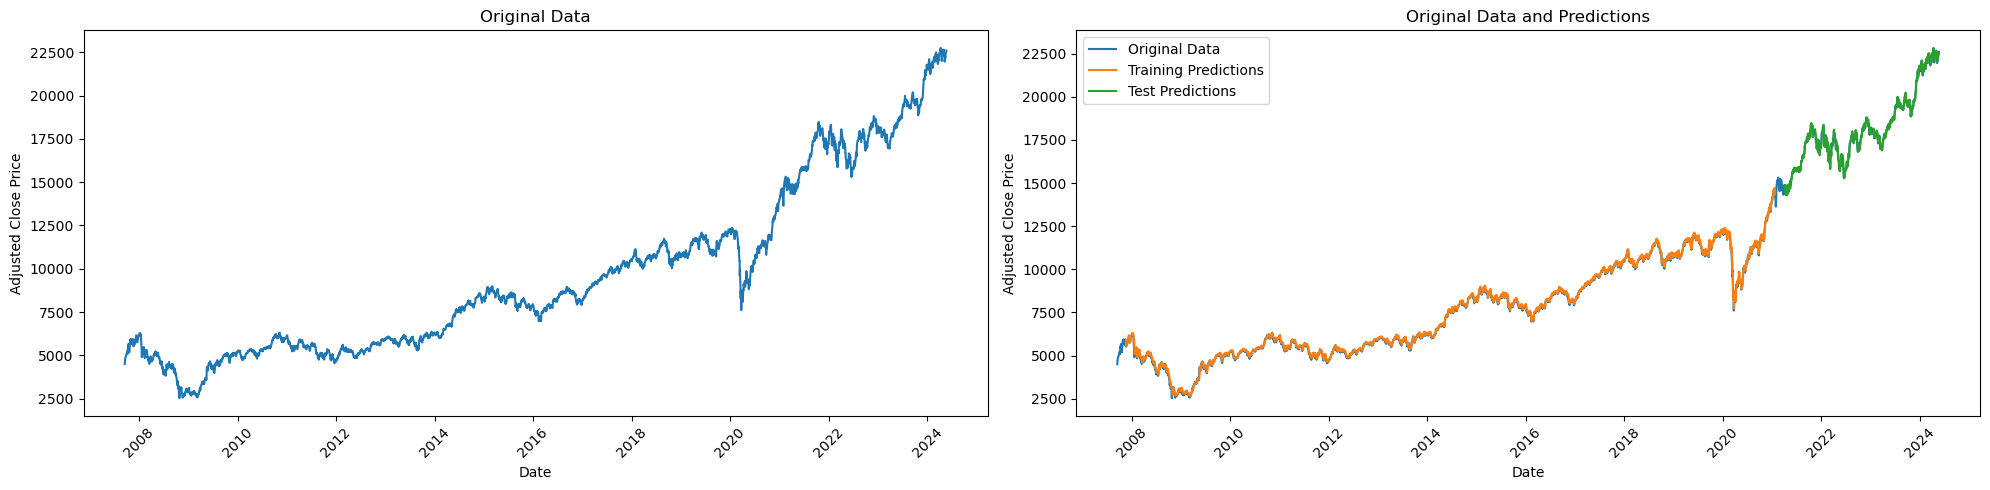

In [23]:
df3 = spy['Adj Close'] 
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 2)  
plt.plot(df3.index, scaler.inverse_transform(df2), label='Original Data')
plt.plot(df3.index[seq_len:len(train_predict) + seq_len], train_predict, label='Training Predictions')
plt.plot(df3.index[len(train_predict) + (seq_len * 2):], test_predict, label='Test Predictions')
plt.title('Original Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(1, 2, 1) 
plt.plot(df3.index, scaler.inverse_transform(df2), label='Original Data')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()
